In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import dask.dataframe as dd
from geopy.distance import geodesic
import string
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, skew

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline

**🧠 Feature Selection Overview**

With a wide range of raw, engineered, and encoded features now available, the next critical step is **Feature Selection** — identifying which variables are truly valuable for predicting fraudulent transactions.

This stage helps to:

- Remove noisy or redundant features
- Improve model performance and interpretability
- Reduce training time and risk of overfitting

We’ll apply statistical tests and model-based techniques to rank feature importance and retain only the most informative predictors for the final fraud detection model.


In [3]:
dir = '../csv/'
fname = 'sample_300k_2020'

In [54]:
df_BASE = pd.read_pickle(fname + '_feat_eng_pruned.pkl')

In [8]:
df_sampled = df_BASE.sample(15000, random_state=42)
df_sampled = df_sampled.reset_index(drop=True)
df_sampled.to_csv('feat_sel_15k_sampled.csv', index=False)

In [55]:
print('df_BASE shape: ' + str(df_BASE.shape))
print(df_BASE.info())

df_BASE shape: (299996, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 299996 entries, 70705 to 127819
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   gender                        299996 non-null  object 
 1   unix_time                     299996 non-null  int32  
 2   category                      299996 non-null  int32  
 3   is_fraud                      299996 non-null  int32  
 4   region                        299996 non-null  object 
 5   trans_day_of_week             299996 non-null  int32  
 6   is_weekend                    299996 non-null  int32  
 7   trans_hour                    299996 non-null  int32  
 8   trans_time_segment            299996 non-null  object 
 9   age_group                     299996 non-null  int32  
 10  cc_type                       299996 non-null  object 
 11  area_cat                      299996 non-null  int32  
 12  distance         

In [56]:
df_feat_sel = df_BASE.copy()

In [57]:
df_feat_sel.nunique()

gender                               2
unix_time                       296925
category                            14
is_fraud                             2
region                               4
trans_day_of_week                    7
is_weekend                           2
trans_hour                          24
trans_time_segment                   4
age_group                            6
cc_type                              8
area_cat                             2
distance                        299996
job_cat                             17
log_amt                          30441
log_time_since_last_trans       265016
log_city_pop                      5880
trans_hour_x_is_weekend             48
category_x_trans_day_of_week        97
age_group_x_category                80
dtype: int64

*Encode string features* - required for the feature selection process

In [58]:
df_encoded = df_feat_sel.copy()
# Identify string (object) columns
string_cols = df_encoded.select_dtypes(include='object').columns.tolist()
print(string_cols)
df_encoded[string_cols].nunique()

['gender', 'region', 'trans_time_segment', 'cc_type', 'job_cat', 'trans_hour_x_is_weekend', 'category_x_trans_day_of_week', 'age_group_x_category']


gender                           2
region                           4
trans_time_segment               4
cc_type                          8
job_cat                         17
trans_hour_x_is_weekend         48
category_x_trans_day_of_week    97
age_group_x_category            80
dtype: int64

In [59]:
# Apply Label Encoding to string columns
label_encoders = {}

for col in string_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

df_encoded.info()
# Show encoded string columns
df_encoded[string_cols].head()

<class 'pandas.core.frame.DataFrame'>
Index: 299996 entries, 70705 to 127819
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   gender                        299996 non-null  int32  
 1   unix_time                     299996 non-null  int32  
 2   category                      299996 non-null  int32  
 3   is_fraud                      299996 non-null  int32  
 4   region                        299996 non-null  int32  
 5   trans_day_of_week             299996 non-null  int32  
 6   is_weekend                    299996 non-null  int32  
 7   trans_hour                    299996 non-null  int32  
 8   trans_time_segment            299996 non-null  int32  
 9   age_group                     299996 non-null  int32  
 10  cc_type                       299996 non-null  int32  
 11  area_cat                      299996 non-null  int32  
 12  distance                      299996 non-null

,gender,region,trans_time_segment,cc_type,job_cat,trans_hour_x_is_weekend,category_x_trans_day_of_week,age_group_x_category
70705,0,0,1,6,10,28,55,47
69722,0,0,2,6,10,34,4,39
69411,0,0,2,6,10,33,40,40
70857,0,0,0,6,10,14,65,48
69729,0,0,1,6,10,20,65,48


In [60]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge

In [61]:
y=df_encoded['is_fraud']
X = df_encoded.drop(columns=['is_fraud'])

In [62]:

#Fit models and determine if a feature is selected (1) or not (0)
lasso = Lasso(alpha=0.01).fit(X, y)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

#Fit Ridge model
ridge = Ridge(alpha=0.01).fit(X, y)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

svm = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
svm_selected = (np.abs(svm.coef_[0]) > 0).astype(int)

gb = GradientBoostingClassifier().fit(X, y)
gb_selected = (gb.feature_importances_ > 0).astype(int)

rf = RandomForestClassifier().fit(X, y)
rf_selected = (rf.feature_importances_ > 0).astype(int)

# Create a DataFrame to store results
selection_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso': lasso_selected, 
    'SVM': svm_selected,
    'GradientBoost': gb_selected,
    'RandomForest': rf_selected,
    'Ridge': ridge_selected
})

# Sum the number of selections for each feature
selection_df['Sum'] = selection_df[['Lasso', 'SVM', 'GradientBoost', 'RandomForest','Ridge']].sum(axis=1)

# Output the results
print(selection_df.sort_values('Sum', ascending=False))


                         Feature  Lasso  SVM  GradientBoost  RandomForest  \
2                       category      1    1              1             1   
17  category_x_trans_day_of_week      1    1              1             1   
16       trans_hour_x_is_weekend      1    1              1             1   
6                     trans_hour      1    1              1             1   
13                       log_amt      1    1              1             1   
1                      unix_time      1    1              1             1   
9                        cc_type      0    1              1             1   
11                      distance      0    1              1             1   
15                  log_city_pop      0    1              1             1   
14     log_time_since_last_trans      0    1              1             1   
12                       job_cat      0    1              1             1   
18          age_group_x_category      0    1              1             1   

In [63]:
selected_features = selection_df[selection_df['Sum'] >= 4]['Feature'].tolist()
print(selected_features)
print(len(selected_features))

#not including 'is_fraud' column
#['unix_time', 'category', 'region', 'trans_hour', 'trans_time_segment', 'cc_type', 'distance', 'job_cat', 'log_amt', 'log_time_since_last_trans', 'log_city_pop', 'trans_hour_x_is_weekend', 'category_x_trans_day_of_week', 'age_group_x_category']

['unix_time', 'category', 'region', 'trans_day_of_week', 'trans_hour', 'trans_time_segment', 'cc_type', 'distance', 'job_cat', 'log_amt', 'log_time_since_last_trans', 'log_city_pop', 'trans_hour_x_is_weekend', 'category_x_trans_day_of_week', 'age_group_x_category']
15


**🧠 Feature Selection Consensus Across Models**

We compared feature importance across five different models — **Lasso**, **Linear SVM**, **Gradient Boosting**, **Random Forest**, and **Ridge** — using binary indicators (`1` = selected, `0` = not selected). The goal is to identify features that are consistently valuable for fraud prediction.

---

**🏆 Universally Selected Features (5/5 Models)**  
These features were selected by **all five models**, indicating **high and stable predictive power**:

- `category`
- `category_x_trans_day_of_week`
- `trans_hour_x_is_weekend`
- `trans_hour`
- `log_amt`
- `unix_time`

✅ These are strong candidates for core features in the final model.

---

**🔶 Strong Features (Selected by 4 Models)**  
Selected by **4/5 models**, these features also show reliable importance:

- `cc_type`
- `distance`
- `log_city_pop`
- `log_time_since_last_trans`
- `job_cat`
- `age_group_x_category`
- `trans_time_segment`
- `region`

➡️ These should be retained and explored further during modeling.

---

**⚖️ Moderately Important (Selected by 3 Models)**  
- `age_group`
- `trans_day_of_week`
- `gender`

🔍 May add value depending on the model type or in combination with other features.

---

**📉 Lower Agreement (Selected by 2 Models)**  
- `area_cat`
- `is_weekend`

These features show lower consensus and may have **marginal standalone value**, but could still be useful in interactions or for specific fraud patterns.

---

**✅ Conclusion**

- Focus your core feature set around features selected with a **selection concensus by equal or more than 4 models**.
- Retain the next-tier predictors for further experimentation or model-specific tuning.


In [64]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299996 entries, 70705 to 127819
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   gender                        299996 non-null  int32  
 1   unix_time                     299996 non-null  int32  
 2   category                      299996 non-null  int32  
 3   is_fraud                      299996 non-null  int32  
 4   region                        299996 non-null  int32  
 5   trans_day_of_week             299996 non-null  int32  
 6   is_weekend                    299996 non-null  int32  
 7   trans_hour                    299996 non-null  int32  
 8   trans_time_segment            299996 non-null  int32  
 9   age_group                     299996 non-null  int32  
 10  cc_type                       299996 non-null  int32  
 11  area_cat                      299996 non-null  int32  
 12  distance                      299996 non-null

**📦 Find Columns suitable for One-Hot Encoding**

Not needed, features were numerically encoded prior to feature selection, besides the number of features on tree based models there is no real advantage for encoding vs one-hot and vice versa.  

In [47]:
# Identify object columns with low cardinality suitable for one-hot encoding
def identify_1hot_candidates(df):
    one_hot_candidates = [
        col for col in df.columns
        if df[col].dtype == 'object' and df[col].nunique() <= 10
    ]

    # Create a summary of these columns with their unique value counts
    one_hot_summary = {
        'column': one_hot_candidates,
        'unique_values': [df[col].nunique() for col in one_hot_candidates]
    }

    print(pd.DataFrame(one_hot_summary).sort_values(by='unique_values', ascending=False))
    
    return one_hot_candidates

**📦 Found Columns suitable for One-Hot Encoding**

These categorical features have a small number of unique values and are ideal candidates for one-hot encoding:

| Column               | Unique Values |
|----------------------|----------------|
| `cc_type`            | 8              |
| `region`             | 4              |
| `trans_time_segment` | 4              |
| `gender`             | 2              |


In [ ]:
def one_hot_encode(df, cols):
    return pd.get_dummies(df, columns=cols, drop_first=False)
    # Perform one-hot encoding 
    #df_feat_eng = pd.get_dummies(df_feat_eng, columns=one_hot_candidates, drop_first=true)
    #df_feat_eng.head()

In [65]:
df_encoded.to_pickle(fname + '_enc_full.pkl')


In [52]:
df_4_model_selected_feat = df_encoded[selected_features + ['is_fraud']].copy()
df_4_model_selected_feat.nunique()

# no needfor 1hot encoding as all selected features are numerical
#print(df_4_model_selected_feat.info())
#one_hot_candidates = identify_1hot_candidates(df_4_model_selected_feat)

df_4_model_selected_feat.to_pickle(fname + '_enc_feat_selected.pkl')


In [50]:
df_4_model_full_feat = df_encoded.copy()
df_4_model_full_feat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299996 entries, 70705 to 127819
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   gender                        299996 non-null  int64  
 1   unix_time                     299996 non-null  int32  
 2   category                      299996 non-null  int32  
 3   is_fraud                      299996 non-null  int32  
 4   region                        299996 non-null  int64  
 5   trans_day_of_week             299996 non-null  int32  
 6   is_weekend                    299996 non-null  int32  
 7   trans_hour                    299996 non-null  int32  
 8   trans_time_segment            299996 non-null  int64  
 9   age_group                     299996 non-null  int32  
 10  cc_type                       299996 non-null  int64  
 11  area_cat                      299996 non-null  int32  
 12  distance                      299996 non-null

In [ ]:
df_4_model_full_feat = df_encoded.copy()
df_4_model_full_feat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299996 entries, 70705 to 127819
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   gender                        299996 non-null  int64  
 1   unix_time                     299996 non-null  int32  
 2   category                      299996 non-null  int32  
 3   is_fraud                      299996 non-null  int32  
 4   region                        299996 non-null  int64  
 5   trans_day_of_week             299996 non-null  int32  
 6   is_weekend                    299996 non-null  int32  
 7   trans_hour                    299996 non-null  int32  
 8   trans_time_segment            299996 non-null  int64  
 9   age_group                     299996 non-null  int32  
 10  cc_type                       299996 non-null  int64  
 11  area_cat                      299996 non-null  int32  
 12  distance                      299996 non-null

**⚖️ Handling Class Imbalance: Focused Techniques**

Fraud detection datasets often contain a **severe class imbalance**, where fraudulent cases make up only a tiny portion of the data. To build models that effectively detect fraud, we must address this imbalance directly.

---

**🔁 Resampling Techniques**

- **Random Oversampling (ROS)**  
  - Duplicates minority class samples to balance the dataset.  
  - ✅ Simple and effective, but may cause overfitting due to repeated examples.

- **Random Undersampling (RUS)**  
  - Removes samples from the majority class.  
  - ✅ Fast and memory-efficient, but may lose valuable data.

- **SMOTE (Synthetic Minority Over-sampling Technique)**  
  - Generates **synthetic** samples for the minority class by interpolating between existing examples.  
  - ✅ More generalizable than ROS, reduces overfitting.

- **SMOTETomek**  
  - Combines **SMOTE** with **Tomek Links** (a cleaning technique that removes borderline majority samples).  
  - ✅ Enhances boundary clarity between classes, improving class separation.

---

**🎯 Evaluation: Why Precision Matters**

- In fraud detection, **precision** is critical:
  - A high precision means **fewer false positives**, reducing costs associated with incorrectly flagging legitimate transactions.
- Must be balanced with **recall** to ensure actual fraud cases are not missed.

---

**✅ Conclusion**

Use resampling techniques like **SMOTE or SMOTETomek** for smart minority class augmentation, and monitor **precision** (alongside recall and F1-score) to ensure your model is both accurate and trustworthy in a real-world fraud detection setting.


In [4]:
#df_balance = pd.read_pickle(fname + '_enc_full.pkl')
df_balance = pd.read_pickle(fname + '_enc_feat_selected.pkl')
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299996 entries, 70705 to 127819
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   unix_time                     299996 non-null  int32  
 1   category                      299996 non-null  int32  
 2   region                        299996 non-null  int64  
 3   trans_hour                    299996 non-null  int32  
 4   trans_time_segment            299996 non-null  int64  
 5   cc_type                       299996 non-null  int64  
 6   distance                      299996 non-null  float64
 7   job_cat                       299996 non-null  int64  
 8   log_amt                       299996 non-null  float64
 9   log_time_since_last_trans     299996 non-null  float64
 10  log_city_pop                  299996 non-null  float64
 11  trans_hour_x_is_weekend       299996 non-null  int64  
 12  category_x_trans_day_of_week  299996 non-null

In [ ]:
#df_sampled = df_balance.sample(n=15000, random_state=42)
#df_sampled.to_csv('sample_bal_15k.csv', index=False)

In [ ]:
#df_XXXX = df_balance.copy()

In [ ]:
#df_XXXX = df_XXXX.drop(columns=['trans_hour_x_is_weekend', 'category_x_trans_day_of_week', 'age_group_x_category'])
#df_XXXX.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299996 entries, 70705 to 127819
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   unix_time                  299996 non-null  int32  
 1   category                   299996 non-null  int32  
 2   region                     299996 non-null  int64  
 3   trans_hour                 299996 non-null  int32  
 4   trans_time_segment         299996 non-null  int64  
 5   cc_type                    299996 non-null  int64  
 6   distance                   299996 non-null  float64
 7   job_cat                    299996 non-null  int64  
 8   log_amt                    299996 non-null  float64
 9   log_time_since_last_trans  299996 non-null  float64
 10  log_city_pop               299996 non-null  float64
 11  is_fraud                   299996 non-null  int32  
dtypes: float64(4), int32(4), int64(4)
memory usage: 25.2 MB


In [5]:
df_balance['is_fraud'].value_counts()

is_fraud
0    298422
1      1574
Name: count, dtype: int64

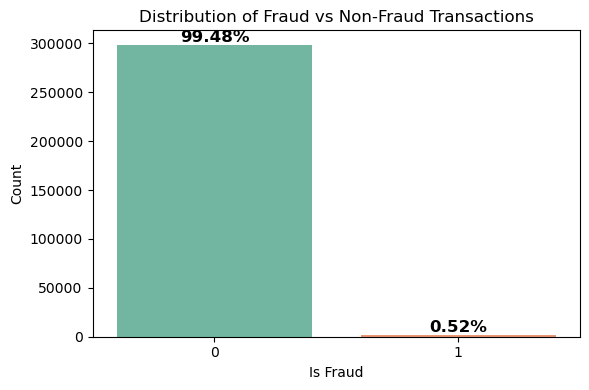

In [69]:
# fraud distribution plotting function
def plot_fraud_distribution(df, target_col='is_fraud'):
    # Calculate percentage distribution
    total = len(df)
    percentages = df[target_col].value_counts(normalize=True) * 100

    # Plot the countplot
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(data=df, x=target_col, palette="Set2")

    # Annotate with percentage labels
    for p in ax.patches:
        label = f'{percentages[int(p.get_x() + p.get_width() / 2)]:.2f}%'
        ax.annotate(label, (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title("Distribution of Fraud vs Non-Fraud Transactions")
    plt.xlabel("Is Fraud")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Run the function
plot_fraud_distribution(df_balance, 'is_fraud')

**based on class 8 imbalanced data loans**

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_balance.drop('is_fraud',axis=1), df_balance['is_fraud'], test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df_XXXX.drop('is_fraud',axis=1), df_balance['is_fraud'], test_size=0.3, random_state=42)


In [8]:
y_test.value_counts()

is_fraud
0    89557
1      442
Name: count, dtype: int64

In [9]:
# Define the classification metrics function
def classificationMetrics(y, yhat):
    metrics = {
        "Accuracy": accuracy_score(y, yhat),
        "Precision": precision_score(y, yhat),
        "Recall": recall_score(y, yhat),
        "F1-Score": f1_score(y, yhat)
    }
    return metrics


In [10]:

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

classificationMetrics(y_test, y_pred)

{'Accuracy': 0.9992222135801508,
 'Precision': 0.9946808510638298,
 'Recall': 0.8461538461538461,
 'F1-Score': 0.9144254278728606}

**🌲 Random Forest Classifier Evaluation - No balancing**
---
| Metric     | Value     | Interpretation |
|------------|-----------|----------------|
| **Accuracy**   | 99.92%    | Overall, the model correctly predicts nearly all transactions — excellent general performance. |
| **Precision**  | 99.47%    | When the model predicts fraud, it's correct 99.5% of the time — very few false positives. |
| **Recall**     | 84.62%    | The model detects about 85% of actual frauds — some fraudulent cases are still missed. |
| **F1-Score**   | 91.44%    | Strong balance between precision and recall — the model performs very well overall. |


In [16]:

techniques = {
    "ROS": RandomOverSampler(random_state=48),
    "RUS": RandomUnderSampler(random_state=55),
    "SMOTE": SMOTE(random_state=69),
    "SMOTETomek": SMOTETomek(random_state=12)
}

# Evaluate and collect results using list comprehension
results = [
    {
        "Technique": name,
        "Accuracy": accuracy_score(y_test, model.predict(X_test)),
        "Precision": precision_score(y_test, model.predict(X_test)),
        "Recall": recall_score(y_test, model.predict(X_test)),
        "F1-Score": f1_score(y_test, model.predict(X_test))
    }
    for name, technique in techniques.items()
    for model in [RandomForestClassifier(random_state=42).fit(*technique.fit_resample(X_train, y_train))]
]
# Display results
results_df = pd.DataFrame(results)
print(results_df)

c:\Users\DCervin\.conda\envs\ds18_ml-proj1\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\DCervin\.conda\envs\ds18_ml-proj1\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\DCervin\.conda\envs\ds18_ml-proj1\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\DCervin\.conda\envs\ds18_ml-proj1\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_n

    Technique  Accuracy  Precision    Recall  F1-Score
0         ROS  0.999222   1.000000  0.841629  0.914005
1         RUS  0.979278   0.186702  0.959276  0.312569
2       SMOTE  0.999067   0.922170  0.884615  0.903002
3  SMOTETomek  0.999000   0.909302  0.884615  0.896789


**⚖️ Comparison of Imbalance Handling Techniques**

We evaluated four popular techniques for handling imbalanced data in the context of fraud detection:

| Technique    | Accuracy | Precision | Recall  | F1-Score |
|--------------|----------|-----------|---------|----------|
| **ROS**      | 0.9992   | 1.0000    | 0.8416  | 0.9140   |
| **RUS**      | 0.9793   | 0.1867    | 0.9593  | 0.3126   |
| **SMOTE**    | 0.9991   | 0.9222    | 0.8846  | 0.9030   |
| **SMOTETomek** | 0.9990 | 0.9093    | 0.8846  | 0.8968   |

---

**📌 Key Observations:**

- **ROS (Random Oversampling)**  
  - Achieves **perfect precision** (1.0), meaning all predicted frauds were actual frauds.
  - **Recall** is solid but not perfect → some fraud cases were still missed.
  - **F1-Score** is highest, indicating the best balance overall.
  - 🔥 **Best overall performance** but may be slightly overfitting due to duplicate samples.

- **RUS (Random Undersampling)**  
  - Very **high recall** (95.9%) — catches almost all frauds.
  - But **precision drops drastically** (18.7%) — lots of false positives.
  - ⚠️ Low **F1-Score** — this model sacrifices too much precision to catch more fraud.
  - 🛑 **Not ideal** unless the goal is to catch every fraud regardless of false alarms.

- **SMOTE**  
  - Strong balance: **high recall and precision**.
  - Slightly less aggressive than ROS but avoids its risk of overfitting.
  - ✅ Great choice for balanced performance.

- **SMOTETomek**  
  - Very similar to SMOTE but slightly lower precision.
  - May benefit from better class boundary refinement using Tomek links.

---

**🔍 What's the Problem?**

- **RUS** is too aggressive — removing too much data from the majority class leads to a high number of false positives (low precision).
- Other techniques like **ROS, SMOTE, and SMOTETomek** perform well, but **none achieve perfect recall** — meaning **some frauds are still missed**, which can be costly.

---

**✅ Conclussions**

- Prefer **SMOTE or ROS** for production — they offer strong recall and excellent precision.
- Consider **threshold tuning** or **ensemble stacking** to squeeze out more recall.
- Monitor **business impact** of missed frauds vs. false positives to guide final strategy.


In [44]:
confusion_matrix(y_test,y_pred)

array([[89555,     2],
       [   68,   374]], dtype=int64)

SMOTE

In [45]:
smote = SMOTE()

In [49]:
X_smote, y_smote = smote.fit_resample(X_train, y_train)
model.fit(X_smote,y_smote)
print('no SMOTE:')
print(confusion_matrix(y_test,y_pred))
pred_smote = model.predict(X_test)
print('SMOTE:')
print(confusion_matrix(y_test,pred_smote))

no SMOTE:
[[89555     2]
 [   68   374]]
SMOTE:
[[89526    31]
 [   50   392]]


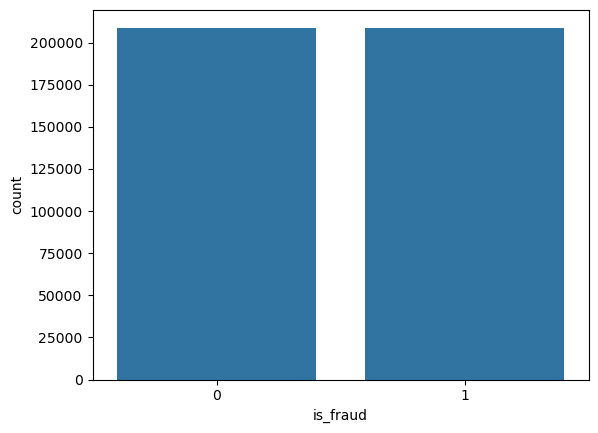

In [ ]:
df_smote = pd.DataFrame(X_smote, columns=X_train.columns)
df_smote['is_fraud'] = y_smote

sns.countplot(x='is_fraud', data=df_smote)
plt.show()